# 综述
产出不是每个词的概率（虽然是前溃神经网络），而是词向量（word embedding），可以计算词之间的相似度，无监督学习，最好加上特定任务更容易发挥他的功效，比如说youtobe的DNN推荐。

包括2个重要的模型：CBOW（给定上下文，中心词出现概率）与Skip-gramm（给定中心词，一定距离内，词o出现概率）

训练：Hierarchical Softmax + Huffman树;Negative Sampling（速度更快，logloss）

优先参考xinrong的论文

In [1]:
# 执行获取论文
from IPython.display import IFrame
IFrame('https://arxiv.org/pdf/1411.2738.pdf', width=950, height=450)

# 词向量
不采用HS与NG Sample的原始网络：$W_{V \times N}$中每一行就是对于的词向量。

> 一个有趣点：input-hidden层输出，相当于将W矩阵对应的词i行

HS：则是root节点参数矩阵

NG Sample：隐藏层参数矩阵

## CBOW
图参考Figure 3,第6页

input：Avg(输入上下文词的one-hot)，label：中间词，优化目标，最大化中心词概率

## Skip-Gram
图参考Figure 3,第8页

input：输入词one-hot，label：上下文词，优化目标：$\prod $上下文词概率

# 训练优化

## HS
第一步：根据词汇表以及词频构建Huffman树，root节点想对于projection矩阵，内部节点相当于hidden层，根节点相当于softmax（可以验证：叶子节点概率和=1，Huffman树构建相同，从Figure 4推，w2+w1=上层点，于是，叶子节点就变成了分层softmax成了明确定义的多项式分布）

第二步：根据模型是Skip-Gramm还是CBOW，最大化随机游走概率，SGD求解

每次实例上下文词训练复杂度降低到了O(log V)

## Negative Sampling
每次只更新其中一个样本，label=1需要更新，再采样几个负样例（采样概率通常用词的uniform分布）

效率更过，实践效果更好

# gensim的word2vec实践
## 分词：jieba
[fxsjy/jieba--github](https://github.com/fxsjy/jieba)

[models.word2vec – Word2vec embeddings](https://radimrehurek.com/gensim_3.8.3/models/word2vec.html)

以三国为例切分词，并保存

## 安装gensim

```bash
pip install gensim
```

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import jieba
from gensim.models import word2vec
from gensim.models import Word2Vec
from string import punctuation
import re

In [5]:
# 读取符号表
# 中英文符号
punc = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”？，！《》【】（）、。：；’‘……￥·"""
dicts={i:'' for i in punc}
punc_table=str.maketrans(dicts)

In [19]:
# 中文切词
def cut_cn(file_in="../../../learnMLData/三国演义.txt", file_out="../../../learnMLData/三国演义_cut.txt"):
    with open(file_in,encoding='utf-8') as fp, open(file_out, 'w') as fp_w:
        for line in fp.readlines():
            line = line.strip()
            if len(line) == 0:continue
            doc_cut  = jieba.cut(line)
            # 保存到本地
            cut_line = " ".join(doc_cut)
            #cut_line = re.sub(r"[{}]+".format(punc)," ",cut_line)
            #print(cut_line)
            new_s=cut_line.translate(punc_table)
            new_s = re.sub(" +", " ", new_s)
            fp_w.write(new_s + "\n")

In [20]:
# 默认模式切词
#with open("../../../learnMLData/三国演义.txt") as fp:
#    doc_cut  = jieba.cut(fp.read())
#    # 保存到本地
#    with open("../../../learnMLData/三国演义_cut.txt", 'w') as fp_w:
#        fp_w.write(" ".join(doc_cut))

In [21]:
cut_cn("../../../learnMLData/三国演义.txt", "../../../learnMLData/三国演义_cut.txt")

In [6]:
#!cat ../../../learnMLData/三国演义_cut.txt|more


In [7]:
# 设置日志级别，保留不被切碎词
import logging
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.ERROR)
# 别被切碎了
jieba.suggest_freq('邢道荣', True)
jieba.suggest_freq('二弟', True)
jieba.suggest_freq('三弟', True)
jieba.suggest_freq('云长', True)
jieba.suggest_freq('翼徳', True)
jieba.suggest_freq('子龙', True)
jieba.suggest_freq('公瑾', True)
jieba.suggest_freq('袁绍', True)
jieba.suggest_freq('孙夫人', True)
jieba.suggest_freq('刘玄德', True)
jieba.suggest_freq('玄德', True)
jieba.suggest_freq('曹孟德', True)
jieba.suggest_freq('孔明', True)
jieba.suggest_freq('诸葛孔明', True)
jieba.suggest_freq('关云长', True)

40

## word2vec模型训练与保存
hs:0表示负采样，1表示层次softmax

min_count：最小次数过滤

window：上下文窗口

In [8]:
# 按行读取文件 
sentences = word2vec.LineSentence("../../../learnMLData/三国演义_cut.txt")
# 参考：https://radimrehurek.com/gensim/models/word2vec.html,搜索：gensim.models.word2vec.Word2Vec

# 负采样
xingdaorong_model = word2vec.Word2Vec(sentences, hs=0, min_count=5,window=5)  
xingdaorong_model.save("../../../learnMLData/xingdaorong_word2vec.model")

## 模型效果

In [9]:
saved_model = Word2Vec.load("../../../learnMLData/xingdaorong_word2vec.model")

In [10]:
# 输出相似度最高词
for key in saved_model.wv.similar_by_word('玄德', topn =10):
    if len(key[0]) < 10 and len(key[0]) >= 2: 
        if key[1] >= 0.9:
            print(key[0], key[1])
        

吕布 0.9966903328895569
后面 0.9959416389465332
张飞 0.9956457614898682
鼓响 0.9955155849456787
人马 0.9954967498779297
引军 0.9953625202178955


In [11]:
# 计算相似度
saved_model.wv.similarity('玄德', '吕布')

0.99669033

In [12]:
# 词向量
saved_model.wv["玄德"].tolist()[0:10]

[0.38343197107315063,
 0.3044130802154541,
 0.022032493725419044,
 -0.35086163878440857,
 -0.565599799156189,
 -0.33796486258506775,
 -0.29603323340415955,
 0.5504494309425354,
 -0.01562567986547947,
 0.7781139612197876]

## 增量更新
更新词汇表后，词向量有变化

In [13]:
cut_cn("../../../learnMLData/三国志.txt", "../../../learnMLData/三国志_cut.txt")

In [14]:
sentences = word2vec.LineSentence("../../../learnMLData/三国志_cut.txt")
saved_model.build_vocab(sentences, update=True)
saved_model.train(sentences, total_examples=saved_model.corpus_count, epochs=saved_model.iter)

/home/hdw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(2218152, 2979480)

In [15]:
saved_model.wv["玄德"].tolist()[0:10]

[0.38100939989089966,
 0.25874558091163635,
 0.03287798911333084,
 -0.2585216462612152,
 -0.4509778320789337,
 -0.36657261848449707,
 -0.2171829491853714,
 0.49081605672836304,
 0.012886266224086285,
 0.6854092478752136]

# C代码中疑问测试

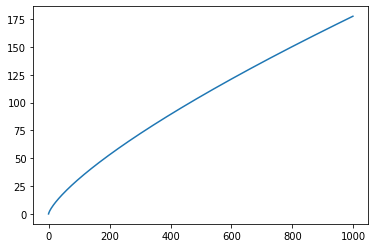

In [16]:
# CPP代码中：负采样中频率，
x = np.random.rand(1000) * 1000
x.sort()
y = [math.pow(i, 0.75) for i in x]
fig, ax = plt.subplots()
ax = plt.gca()

ax.plot(x, y)
plt.show()

# Ref
[word2vec Parameter Learning Explained](https://arxiv.org/pdf/1411.2738.pdf)、[\[论文翻译\]word2vec Parameter Learning Explained](https://zhuanlan.zhihu.com/p/183161311)

[NLP之——Word2Vec详解](https://www.cnblogs.com/guoyaohua/p/9240336.html)

两篇原始论文：Efficient Estimation of Word Representations in Vector Space，Recurrent Neural Net Language Model，理解上难度有点大

word2vec的C代码：https://github.com/tmikolov/word2vec/blob/master/word2vec.c 方便理解，还可以参考： https://blog.csdn.net/google19890102/article/details/51887344


https://blog.csdn.net/shuihupo/article/details/81540433 切词工具对比(选择jieba：https://github.com/fxsjy/jieba)

https://radimrehurek.com/gensim/ gensim参考，Documentation

[基于Hierarchical Softmax的模型概述](https://www.cnblogs.com/pinard/p/7243513.html) 浅显的介绍了层次softmax的构建

In [ ]:
#IFrame('https://www.cnblogs.com/guoyaohua/p/9240336.html', width=800, height=450)